<a href="https://colab.research.google.com/github/KaifAhmad1/Agri-Llama/blob/main/Finetuned_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Installing Necessary Dependencies:**

In [ ]:
!pip install -qU bitsandbytes
!pip install -qU trl
!pip install -qU transformers
!pip install -qU peft
!pip install -qU optimum
!pip install -qU datasets
!pip install -qU accelerate
!pip install -qU nltk
!pip install -qU rouge_score

**Necessary Imports:**

In [ ]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import bitsandbytes as bnb
import torch
import torch.nn as nn
from peft import LoraConfig, prepare_model_for_kbit_training, get_peft_model
from trl import SFTTrainer
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    TrainingArguments,
    BitsAndBytesConfig,
    pipeline,
    logging
)
from sklearn.model_selection import train_test_split
from datasets import Dataset
from huggingface_hub import notebook_login
from google.colab import drive
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer

**Set Up Environment:**

In [ ]:
notebook_login()
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Load Data:**

In [ ]:
# Load data
file_path = '/content/drive/MyDrive/Network-QA-Dataset.csv'
data = pd.read_csv(file_path)
data

,Questions,Answers,Context Info,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 101,Unnamed: 102,Unnamed: 103,Unnamed: 104,Unnamed: 105,Unnamed: 106,Unnamed: 107,Unnamed: 108,Unnamed: 109,Unnamed: 110
0,What is the scope of the technical specificati...,The scope of the technical specification is de...,"The technical specification, titled ""3GPP TS 2...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Where can specifications and reports for the i...,Specifications and reports for the implementat...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,What are the different restoration indicators ...,The document discusses various restoration ind...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,What procedures are outlined for the restorati...,Procedures for the restoration of data in the ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,In which section can information about the res...,Information about the restoration of data in ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1266,"In the context of CAPIF deployment models, wha...","""NEF implements the CAPIF architecture"" means...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1267,"Explain the concept of ""Distributed deployment...","The ""Distributed deployment of the NEF complia...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1268,"According to Annex D, what is the document's a...",Annex D provides a table (Table D-1) that illu...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1269,What kind of information does Annex E (Configu...,Annex E specifies configuration data for CAPIF...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
network_data = data[['Questions', 'Answers', 'Context Info']]
network_data

,Questions,Answers,Context Info
0,What is the scope of the technical specificati...,The scope of the technical specification is de...,"The technical specification, titled ""3GPP TS 2..."
1,Where can specifications and reports for the i...,Specifications and reports for the implementat...,NaN
2,What are the different restoration indicators ...,The document discusses various restoration ind...,NaN
3,What procedures are outlined for the restorati...,Procedures for the restoration of data in the ...,NaN
4,In which section can information about the res...,Information about the restoration of data in ...,NaN
...,...,...,...
1266,"In the context of CAPIF deployment models, wha...","""NEF implements the CAPIF architecture"" means...",NaN
1267,"Explain the concept of ""Distributed deployment...","The ""Distributed deployment of the NEF complia...",NaN
1268,"According to Annex D, what is the document's a...",Annex D provides a table (Table D-1) that illu...,NaN
1269,What kind of information does Annex E (Configu...,Annex E specifies configuration data for CAPIF...,NaN


In [ ]:
def process_data_sample(example):
    # Extract relevant information from the example
    question = example['Questions']
    answer = example['Answers']
    context_info = example['Context Info']

    # Convert potential NaN values to empty string
    question = str(question)
    answer = str(answer)
    context_info = str(context_info) if pd.notna(context_info) else ""

    # Prepare the processed example for a Question Answering System
    processed_example = (
        "You are a Question Answering System designed to assist users with queries. "
        "Your capabilities include providing technical details, offering implementation guidance, "
        "and staying updated on telecommunications standards.\n\n"
        f"User Query:\n{question}\n\n"
        f"Answer:\n{answer}\n\n"
        f"Context Information:\n{context_info}"
    )
    return processed_example

In [ ]:
# Create 'text' column in 'network_data' by applying 'process_data_sample' to each row's 'Questions', 'Answers', and 'Context Info'
network_data['text'] = network_data[['Questions', 'Answers', 'Context Info']].apply(lambda x: process_data_sample(x), axis=1)

<ipython-input-7-7a9adacdc3c7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  network_data['text'] = network_data[['Questions', 'Answers', 'Context Info']].apply(lambda x: process_data_sample(x), axis=1)


In [ ]:
for i in range(5):
  print(network_data['text'].iloc[i])

You are a Question Answering System designed to assist users with queries. Your capabilities include providing technical details, offering implementation guidance, and staying updated on telecommunications standards.

User Query:
What is the scope of the technical specification mentioned in the document?

Answer:
The scope of the technical specification is defined in Section 1, and it covers restoration procedures within the 3rd Generation Partnership Project (3GPP) for Core Network and Terminals, Release 18.

Context Information:
The technical specification, titled "3GPP TS 23.007 V18.2.0 (2023-06)," is a document developed within the 3rd Generation Partnership Project (3GPP). It falls under the Technical Specification Group Core Network and Terminals and specifically focuses on "Restoration procedures" as part of Release 18.The document outlines various aspects related to restoration procedures within the 3GPP framework. It covers a wide range of topics, including restoration indicat

In [ ]:
# Split data
train_data, test_data = train_test_split(network_data, test_size=0.2, random_state=42)

In [ ]:
# Create datasets for training and evaluation using the datasets library
network_train_data = Dataset.from_pandas(train_data)
network_test_data = Dataset.from_pandas(test_data)

In [ ]:
network_train_data

Dataset({
    features: ['Questions', 'Answers', 'Context Info', 'text', '__index_level_0__'],
    num_rows: 1016
})

In [ ]:
network_test_data

Dataset({
    features: ['Questions', 'Answers', 'Context Info', 'text', '__index_level_0__'],
    num_rows: 255
})

**Pretrained Model:**

In [ ]:
model_name = 'mistralai/Mistral-7B-v0.1'

In [ ]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)

In [ ]:
pretrained_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True,
    low_cpu_mem_usage=True
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
# Tokenization and Padding
tokenizer = AutoTokenizer.from_pretrained(
    model_name,
    trust_remote_code=True,
)
tokenizer.pad_token = tokenizer.eos_token

In [ ]:
# Assess pre-trained model on custom queries
custom_queries = [
    "Is the Emergency Service a subscription service?",
    "What considerations should the HSS follow during emergency registrations?",
    "What are the different restoration indicators discussed in the document?",
    "What procedures are outlined for the restoration of data in the VLR after a failure?",
    "In which section can information about the restoration of data in the GGSN be found?",
    "What is included in the DL NAS TRANSPORT message sent from the AMF to the UE?",
    "How is the SOR-CMCI configured and provided to the UE?",
    "In signal level enhanced network selection, what criteria must be met for the MS to select a PLMN?",
    "What is Minimization of Service Interruption (MINT), and when is it applicable?",
    "What corrective actions does the User Equipment (UE) take in case of a security check failure of System Operator's Roaming (SOR) information during automatic network selection mode?"
]

In [ ]:
for query in custom_queries:
    # Tokenize and generate response
    inputs = tokenizer(query, return_tensors='pt', max_length=512, truncation=True)
    outputs = pretrained_model(**inputs)

    # Access the logits tensor and apply argmax
    logits = outputs.logits
    predicted_index = torch.argmax(logits[0]).item()

    # Decode the predicted index
    generated_text = tokenizer.decode(predicted_index, skip_special_tokens=True)

    # Print the result
    print(f"\nPre-trained Model Assessment - Custom Query:\n{query}\nGenerated Answer:\n{generated_text}\n")


Pre-trained Model Assessment - Custom Query:
Is the Emergency Service a subscription service?
Generated Answer:



Pre-trained Model Assessment - Custom Query:
What considerations should the HSS follow during emergency registrations?
Generated Answer:



Pre-trained Model Assessment - Custom Query:
What are the different restoration indicators discussed in the document?
Generated Answer:



Pre-trained Model Assessment - Custom Query:
What procedures are outlined for the restoration of data in the VLR after a failure?
Generated Answer:



Pre-trained Model Assessment - Custom Query:
In which section can information about the restoration of data in the GGSN be found?
Generated Answer:



Pre-trained Model Assessment - Custom Query:
What is included in the DL NAS TRANSPORT message sent from the AMF to the UE?
Generated Answer:



Pre-trained Model Assessment - Custom Query:
How is the SOR-CMCI configured and provided to the UE?
Generated Answer:



Pre-trained Model Assessment - Custom 

In [ ]:
# Function to calculate BLEU score
def calculate_bleu_score(reference, generated):
    reference_tokens = [reference.split()]
    generated_tokens = generated.split()
    return sentence_bleu(reference_tokens, generated_tokens)

In [ ]:
# Assess pre-trained model on custom queries and calculate BLEU scores
pretrained_bleu_scores = []

for i, query in enumerate(custom_queries):
    # Tokenize and generate response
    inputs = tokenizer(query, return_tensors='pt', max_length=512, truncation=True)
    outputs = pretrained_model(**inputs)

    # Extract token IDs and decode
    generated_token_ids = outputs['logits'][0].argmax(dim=-1).tolist()
    generated_text = tokenizer.decode(generated_token_ids, skip_special_tokens=True)

    # Print the result
    print(f"\nPre-trained Model Assessment - Custom Query:\n{query}\nGenerated Answer:\n{generated_text}\n")

    # Calculate BLEU score
    reference_answer = network_data['Answers'].iloc[i]
    bleu_score = calculate_bleu_score(reference_answer, generated_text)
    pretrained_bleu_scores.append(bleu_score)
    print(f"BLEU Score: {bleu_score}\n")


Pre-trained Model Assessment - Custom Query:
Is the Emergency Service a subscription service?
Generated Answer:
# it worldgency Department of good service?


BLEU Score: 4.983376835072531e-233



/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_


Pre-trained Model Assessment - Custom Query:
What considerations should the HSS follow during emergency registrations?
Generated Answer:
# isations should you boardVA when the situationsations?


BLEU Score: 1.3577841712062768e-232


Pre-trained Model Assessment - Custom Query:
What are the different restoration indicators discussed in the document?
Generated Answer:
# is the best types optionsators? in the article?


BLEU Score: 2.950468235875468e-232


Pre-trained Model Assessment - Custom Query:
What procedures are outlined for the restoration of data in the VLR after a failure?
Generated Answer:
# is are available in the use of a? the eventaultDB? a disaster?


BLEU Score: 1.4183503557344971e-155


Pre-trained Model Assessment - Custom Query:
In which section can information about the restoration of data in the GGSN be found?
Generated Answer:
# the I of I about the company of the be the eventISUS be found?


BLEU Score: 6.3827343968029374e-155


Pre-trained Model Assessment - Cus

In [ ]:
# Function to calculate ROUGE scores
def calculate_rouge_scores(reference, candidate):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = scorer.score(reference, candidate)
    return scores

In [ ]:
# Assess pre-trained model on custom queries and calculate ROUGE scores
pretrained_rouge_scores = {'rouge1': [], 'rouge2': [], 'rougeL': []}

for i, query in enumerate(custom_queries):
    # Tokenize and generate response
    inputs = tokenizer(query, return_tensors='pt', max_length=512, truncation=True)
    outputs = pretrained_model(**inputs)

    # Extract token IDs and decode
    generated_token_ids = outputs['logits'][0].argmax(dim=-1).tolist()
    generated_text = tokenizer.decode(generated_token_ids, skip_special_tokens=True)

    # Print the result
    print(f"\nPre-trained Model Assessment - Custom Query:\n{query}\nGenerated Answer:\n{generated_text}\n")

    # Calculate ROUGE scores
    reference_answer = network_data['Answers'].iloc[i]
    rouge_scores = calculate_rouge_scores(reference_answer, generated_text)
    for metric, score in rouge_scores.items():
        pretrained_rouge_scores[metric].append(score)
        print(f"{metric} Score: {score}\n")


Pre-trained Model Assessment - Custom Query:
Is the Emergency Service a subscription service?
Generated Answer:
# it worldgency Department of good service?


rouge1 Score: Score(precision=0.3333333333333333, recall=0.06666666666666667, fmeasure=0.1111111111111111)

rouge2 Score: Score(precision=0.0, recall=0.0, fmeasure=0.0)

rougeL Score: Score(precision=0.16666666666666666, recall=0.03333333333333333, fmeasure=0.05555555555555555)


Pre-trained Model Assessment - Custom Query:
What considerations should the HSS follow during emergency registrations?
Generated Answer:
# isations should you boardVA when the situationsations?


rouge1 Score: Score(precision=0.2857142857142857, recall=0.07692307692307693, fmeasure=0.12121212121212123)

rouge2 Score: Score(precision=0.0, recall=0.0, fmeasure=0.0)

rougeL Score: Score(precision=0.2857142857142857, recall=0.07692307692307693, fmeasure=0.12121212121212123)


Pre-trained Model Assessment - Custom Query:
What are the different restoration ind

**LoRA and SFT**

In [ ]:
pretrained_model.config.use_cache = False
pretrained_model.config.pretraining_tp = 1
pretrained_model.gradient_checkpointing_enable()
pretrained_model = prepare_model_for_kbit_training(pretrained_model)

In [ ]:
# LoRA Config
peft_config = LoraConfig(
    r=64,
    lora_alpha=16,
    lora_dropout=0.1,
    bias='none',
    task_type="CAUSAL_LM",
    target_modules=["q_proj", "v_proj"]
)

In [ ]:
# Training Arguments
training_arguments = TrainingArguments(
    output_dir='Mistral-Network-QnA-System',
    per_device_train_batch_size=4,
    gradient_accumulation_steps=4,
    optim='paged_adamw_32bit',
    learning_rate=2e-4,
    lr_scheduler_type='cosine',
    save_strategy='epoch',
    logging_steps=10,
    save_steps=10,
    num_train_epochs=1,
    max_steps=200,
    fp16=True,
    warmup_ratio=0.05,
    push_to_hub=False,
)

In [ ]:
# SFT Trainer
trainer = SFTTrainer(
    model=pretrained_model,
    train_dataset=network_train_data,
    peft_config=peft_config,
    dataset_text_field='text',
    args=training_arguments,
    tokenizer=tokenizer,
    packing=False,
    max_seq_length=264
)

Map:   0%|          | 0/1016 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:290: UserWarning: You passed a tokenizer with `padding_side` not equal to `right` to the SFTTrainer. This might lead to some unexpected behaviour due to overflow issues when training a model in half-precision. You might consider adding `tokenizer.padding_side = 'right'` to your code.
  warnings.warn(


In [ ]:
# Train the model
trainer.train()

/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss
10,2.393800
20,1.586800
30,1.307800
40,1.226000
50,1.192600
60,1.213000
70,1.143300
80,1.146100
90,1.078000
100,1.083200


Checkpoint destination directory Mistral-Network-QnA-System/checkpoint-63 already exists and is non-empty.Saving will proceed but saved results may be invalid.
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
Checkpoint destination directory Mistral-Network-QnA-System/checkpoint-127 already exists and is non-empty.Saving will proceed but saved results may be invalid.
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be upda

TrainOutput(global_step=200, training_loss=1.1780118465423584, metrics={'train_runtime': 2678.113, 'train_samples_per_second': 1.195, 'train_steps_per_second': 0.075, 'total_flos': 2.5708172149653504e+16, 'train_loss': 1.1780118465423584, 'epoch': 3.15})

In [ ]:
output_model_dir = "Mistral-finetuned-network"
trainer.model.save_pretrained(output_model_dir)

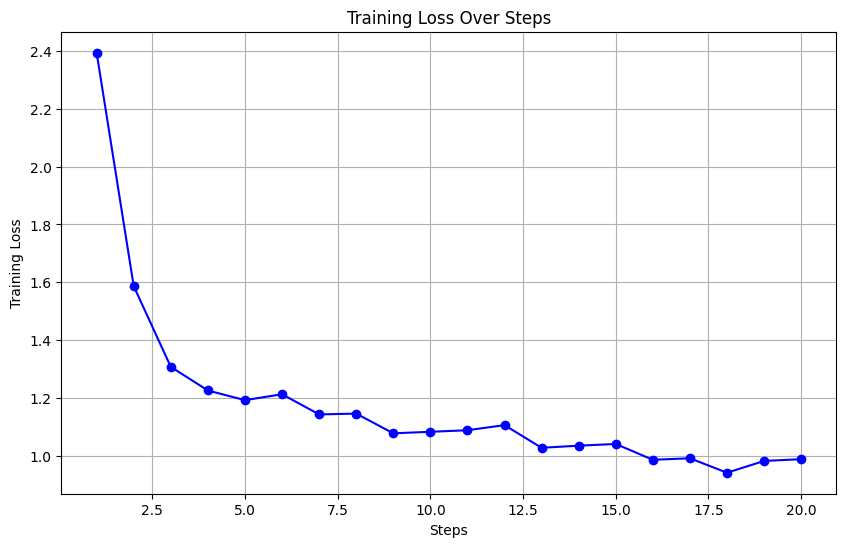

In [ ]:
import matplotlib.pyplot as plt
# Extract training loss values
train_losses = [entry['loss'] for entry in trainer.state.log_history if 'loss' in entry]
# Create a plot using Matplotlib
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, marker='o', linestyle='-', color='b')
plt.title('Training Loss Over Steps')
plt.xlabel('Steps')
plt.ylabel('Training Loss')
plt.grid(True)
plt.show()

In [ ]:
# Push your model to the Hub
pretrained_model.push_to_hub("Mistral-finetuned-network")

KeyboardInterrupt: 